In [ ]:
! pip install yfinance

Texas Instruments was a company that I loved as a kid because they produced a variety of calculators that helped me learn math. In this blog, we try to use the keras implementation of LSTM neural network to predict the stock price of Texas Instruments. First, we use yahoo finance to download all the stock prices of Texas Instruments from 1972 to the present, including Date, Open, High, Low, Close, Adj Close, Volume, 7 columns. and write to TXN.csv

In [ ]:
import yfinance as yf

# Download Texas Instruments stock data
txn_data = yf.download('TXN', start='1972-01-01') # Texas Instruments went on the market in 1972, and 1972 is used as the starting date here.

# Save data to CSV file
txn_data.to_csv('TXN.csv')


We read the stock price data from the csv file into the pandas dataframe, and draw the adjusted stock price into a curve chart.

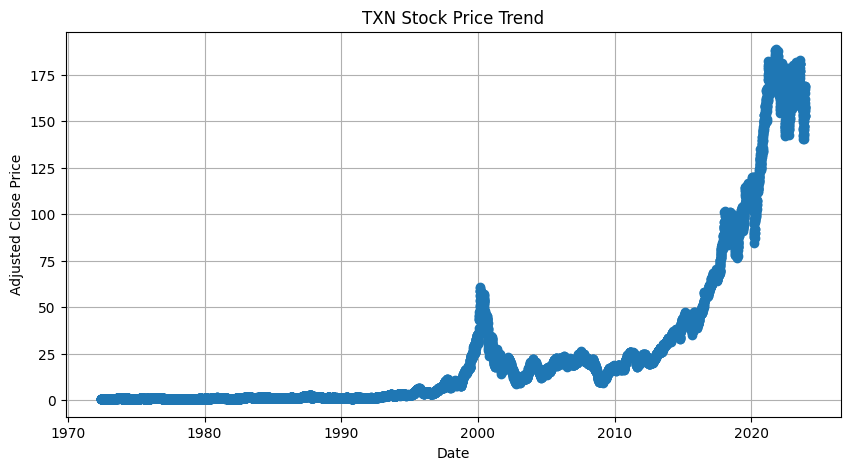

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('TXN.csv')
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Adj Close'], marker='o')
plt.title('TXN Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.show()

Create an LSTM model, including three LSTM layers and two dropout layers, all using the built-in functions of keras. There is no need to care about the details of the layers for the time being.

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(100, input_shape=(50, 1), return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))

model.add(LSTM(100, return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

Preparing data: In this code, result is a list containing all sequences of length 51. Each series consists of 50 consecutive stock closing prices and the closing price on the 51st day. The purpose of this is to create a data set that can be used to train the LSTM model. For the sake of simplicity, our program only uses the adjusted closing prices for training.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('TXN.csv')

data = df['Adj Close'].values

# Create input and output sequences
sequence_length = 50
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length + 1])
result = np.array(result)
print(result.shape)#(12944,51)
# Divide training set and test set
train_test_split = 0.85
n_train = int(train_test_split * result.shape[0])#11002
train = result[:n_train, :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[n_train:, :-1]
y_test = result[n_train:, -1]

# normalized data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape into a shape that meets the LSTM input requirements
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

(12951, 51)


Train the model for a total of 50 epochs. It takes 50 epochs to achieve the current good-looking results. If you only train for 5 epochs, the prediction result will be approximately a straight line.

In [5]:
from keras.models import load_model
import os

model_path = 'TXNmodel.h5'

# Check if the model already exists
if os.path.exists(model_path):
    # Load model
    model = load_model(model_path)
else:
    # Training model
    history = model.fit(
        x_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_test, y_test)
    )
    # Save model
    model.save(model_path)

The training result is the prediction result of the last 15% of the data set. The orange line is the prediction result. It can be seen that the prediction in the past few days was still very accurate.

61/61 [==============================] - 4s 9ms/step


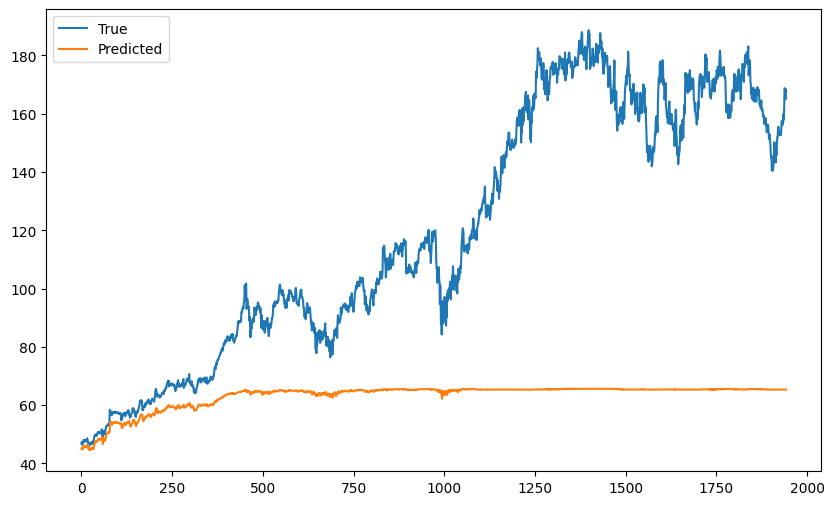

In [6]:
# Use the model to generate predictions
y_pred = model.predict(x_test)

# Plot raw data and predicted results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

344/344 [==============================] - 2s 7ms/step


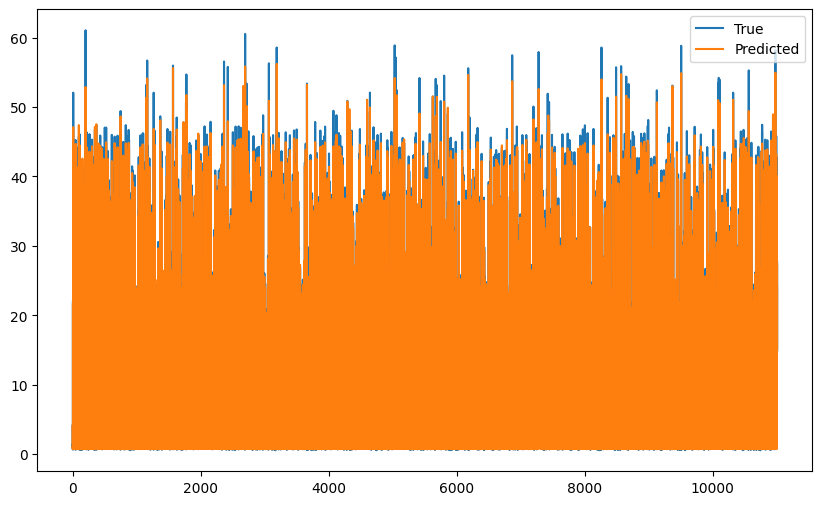

In [7]:
# Use the model to generate predictions
y_pred_train = model.predict(x_train)

# Plot raw data and predicted results
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='True')
plt.plot(y_pred_train, label='Predicted')
plt.legend()
plt.show()